# HPMOR with nltk

###### This is a natural language processing analysis of the popular rationalist fanfiction 'Harry Potter and the Methods of Rationality' (HPMOR) by Eliezer Yudkowsky.   The aim is to i) learn some NLP methods in Python using the nltk package ii) explore some fun hypotheses! 

#### Warning: spoilers alert!

In [1]:
from __future__ import division # Python 2 users only
import nltk, re, pprint
import networkx as nx
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize
from urllib2 import urlopen
from bs4 import BeautifulSoup
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Loading the text 

First, I need to load in the data. I could have got this from the PDF file, but that has a lot of pictures and unwanted formatting that I wouldn't want in the text. So I decided to scrape the text from the HPMOR website, which also has the advantage of having all of the latest chapters as they are written.

In [2]:
# create a function to load in the text of a chapter from the HPMOR site, tokenise and clean the unwanted stuff from the start and the end 
def word_tokenise(url):
    html = urlopen(url).read().decode('utf8')
    raw = BeautifulSoup(html).get_text()          # extract all of the text from the page
    tokens = word_tokenize(raw)                   # tokenise the string (breaking it down into individual words)
    start_index = tokens.index("Caring")+3        # start index
    end_index = tokens.index("FanFiction.net")-11 # end index
    return tokens [start_index:end_index]


In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/Lin/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
# load all of the chapters and extend into one list

text = []

for i in range(1,123):                            # there are 122 chapters
    url = "http://hpmor.com/chapter/%d" %i
    tokens = word_tokenise(url)
    text.extend(tokens)

In [6]:
# convert the list to an nltk.Text object
hpmor = nltk.Text(text)

In [7]:
# check the type
type(hpmor)

nltk.text.Text

### Basic analyses

#### Counting the number of words

Now I am in a position to do some analyses on the text. First I'll find out how many words there are up to the current chapter. 

In [8]:
print "HPMOR has %d words in it" %len(hpmor)

HPMOR has 803046 words in it


#### Lexical dispersion plot

I can use a Lexical Dispersion Plot to show where in the text particular words appear. I've picked a few words that are relevant to the book's themes. Clearly, some words like 'magic' are peppered frequently throughout the text, whereas 'rationality' features surprisingly sparsely.

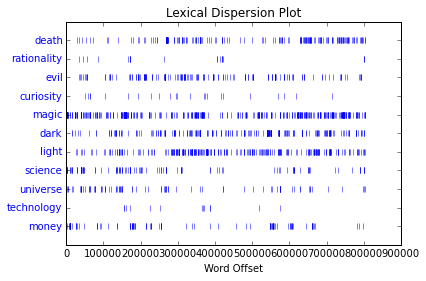

In [9]:
# show where in the text certain words appear
hpmor.dispersion_plot(['death', 'rationality', 'evil', 'curiosity', 'magic', 'dark', 'light', 'science', 'universe', 'technology', 'money'])

#### Similar contexts

The similar function finds all words that have occur in a similar context within the text. This doesn't seem to be highlighting anything particularly interesting for the words I've chosen.

In [10]:
hpmor.similar('magic')

it that you harry this time there what wand them hermione way him he
me the something hogwarts mind father


In [11]:
hpmor.similar('science')

it that you this him hogwarts harry what magic me them malfoy the
course all slytherin something how things power


In [12]:
hpmor.similar('technology')

time ground light wall room end answer distance life air left people
floor water cloak man corner black graveyard money


In [13]:
hpmor.similar('money')

it time life power magic that wand way hogwarts them world thing cloak
paper light book man you students door


#### Hapaxes

Hapaxes are words that occur only once in the text. Sort of like Googlewhacks. There were lots of these and so I've only printed the first  15. What's noticeable is that there are a lot of hyphenated words turning up, which is typical of the author's style of mashing words together.

In [14]:
fd = nltk.FreqDist(hpmor)
hpx = fd.hapaxes()
hpx[:15]

[u'thrice-cursed',
 u'sevens',
 u'LAST',
 u'sstrike',
 u'scold',
 u'lied-to',
 u'three-thirty',
 u'Elen',
 u'immunities',
 u'HAPPENED',
 u'Shocked',
 u'snuggled',
 u'inanimate',
 u'exactly-right',
 u'12AM']

#### Popular words

Next, I'll look at the words that are used many times in the text. I've restricted this to words over 7 letters in length, as without this  you end up with a lot of words like 'and'. The threshold for number of times the word must appear is set at 20. There are a lot of words turning up that are clearly specific to the Harry Potter universe, like 'Dementor' and 'Dumbledore'.

In [15]:
# sort the words that are greater than 7 letters long and occur more than 20 times
long_n_popular = sorted(w for w in set(hpmor) if len(w) > 7 and fd[w] > 20)
long_n_popular[:20]

[u'Actually',
 u'Aftermath',
 u'Animagus',
 u'Bellatrix',
 u'Boy-Who-Lived',
 u'Chaotics',
 u'Christmas',
 u'Comed-Tea',
 u'Dementor',
 u'Dementors',
 u'Department',
 u'Director',
 u'Dumbledore',
 u'Everyone',
 u'Everything',
 u'Felthorne',
 u'Flitwick',
 u'Forbidden',
 u'Galleons',
 u'Goldstein']

#### Collocations

The collocations functions finds pairs of words that frequently occur together. Unsurprisingly, this is picking out a lot of names

In [21]:
# collocations finds the pairs of words that frequently occur together
hpmor.collocations()

Professor Quirrell; Dark Lord; Defense Professor; Professor
McGonagall; Mr. Potter; Harry Potter; old wizard; Harry said; Hermione
Granger; could n't; Miss Granger; Draco Malfoy; Albus Dumbledore;
Severus Snape; Final Exam; Potions Master; Sorting Hat; Death Eaters;
Patronus Charm; Minerva McGonagall


### Character interaction networks

#### Word tokenisation

Next, I want to investigate how the interactions between characters is changing over the course of the book. This could be the precursor to some kind of network analysis. As a first stab, I've decided to use instances of characters mentioned in the same sentence as a proxy for interaction. To do that, I need to retokenise the text into sentences. 

In [22]:
# in order to look at co-occurring words in a sentence, I created a new function that returns a cleaned string of the raw text
def clean_chapter_string(url):
    html = urlopen(url).read().decode('utf8')
    raw = BeautifulSoup(html).get_text()          # extract all of the text from the page
    raw_start = raw.index('Caring') + 14          # raw string start index (for sentence tokenisation)
    raw_end = raw.index('reviews or write ')-8    # raw string end index 
    return raw [raw_start:raw_end]

In [23]:
# Then I appended these strings into the complete raw text
raw_text_string=""

for i in range(1,123):
    url = "http://hpmor.com/chapter/%d" %i
    raw_text_string = raw_text_string + ' ' + clean_chapter_string(url)

In [24]:
# Then use the sent_tokenise function to split up the sentences (the function  works off the basis of a pre-trained Punktd module that can
# differentiate sentence ends from abbreviations etc.)
sentence_list = sent_tokenize(raw_text_string)
num_sentences = len(sentence_list)
sentence_list[:5]

[u'  103: Tests\nChapter 104: The Truth, Pt 1, Riddles and Answers\nChapter 105: The Truth, Pt 2\nChapter 106: The Truth, Pt 3\nChapter 107: The Truth, Pt 4\nChapter 108: The Truth, Pt 5, Answers and Riddles\nChapter 109: Reflections\nChapter 110: Reflections, Pt 2\nChapter 111: Failure, Pt 1\nChapter 112: Failure, Pt 2\nChapter 113: Final Exam\nChapter 114: Shut Up and Do The Impossible\nChapter 115: Shut Up and Do The Impossible, Pt 2\nChapter 116: Aftermath, Something to Protect, Pt 0\nChapter 117: Something to Protect: Minerva McGonagall\nChapter 118: Something to Protect: Professor Quirrell\nChapter 119: Something to Protect: Albus Dumbledore\nChapter 120: Something to Protect: Draco Malfoy\nChapter 121: Something to Protect: Severus Snape\nChapter 122: Something to Protect: Hermione Granger\nNext \xbb\nChapter 1: A Day of Very Low\nProbability\n\nDisclaimer: J. K. Rowling owns Harry Potter, and no one owns the\nmethods of rationality.',
 u'This fic is widely considered to have re

In [25]:
num_sentences

41607

#### Character interactions sentence filter

Above is the first five sentences of the first chapter of the book. It seems to be working ok. Next, I need to make the function that will return a list of the indices where two characters appear. When searching for certain characters, we need to take into account that sometimes they are referred to by different names e.g. Harry can be 'The-Boy-Who-Lived' or just 'Potter'. So after a few interations I decided to pass a list of pre-determined names to the function.

In [32]:
def characters_sentence_indexes(a,b):
    l = [i for i in np.arange(num_sentences) for A in a for B in b if (A in sentence_list[i])*(B in sentence_list[i])]
    return list(set(l))     # first converting to a set removes the duplicates       

In [27]:
# enter lists of possible names for the two characters being examined
Harry_list = ["Harry","Boy-Who-Lived","Potter"]
Draco_list = ["Draco", "Malfoy"]

In [28]:
# apply the function to find the sentence indices where both characters feature
Harry_Draco_sentence_indexes = characters_sentence_indexes(Harry_list,Draco_list)
"the number of sentences where Harry and Draco are both mentioned is %d" %len(Harry_Draco_sentence_indexes)

'the number of sentences where Harry and Draco are both mentioned is 516'

I printed out some of these sentences to check the output, and realised that identifying a character in a text is more complicated than I first thought. Not only is a single character referred to by multiple names, but a name can refer to more than one character. For example, 'Potter' can refer to Harry's dad. ditto for 'Malfoy'. I'm not sure how one would distinguish between these different possibilities; maybe some sort of machine learning technique to look at the surrounding context?

I'll carry on with what I've got for now. It should be able to give a rough idea of where both characters are appearing, even if there are some false positives and missed records. Below are some visualisations of the data.

In [29]:
[sentence_list[i] for i in Harry_Draco_sentence_indexes[45:50]]

[u'There had been a\nPatronus Charm to locate Draco, which Harry had successfully willed\nto take the form of a ball of pure silver light, and the flight of\nAurors had arrived on time to the second.',
 u'"A Maaaalfoy is working with a muuudbloood,\nwhat will all your father\'s frieeeends think -"\n"They\'ll think Malfoys aren\'t as easily manipulated as\nyou seem to believe, Potter!\u202f"',
 u'"Tell Harry," said Draco to the luminous snake, even though\nHarry was standing only a few paces away on the other side of the\nroom, "to, um, beware the green monkey," this being a sign from a\nplay Draco had once seen.',
 u"Harry didn't say anything, so Draco looked up from his book, and\nfelt a twinge of malicious satisfaction at the sad look on Harry's\nface.",
 u"103: Tests\nChapter 104: The Truth, Pt 1, Riddles and Answers\nChapter 105: The Truth, Pt 2\nChapter 106: The Truth, Pt 3\nChapter 107: The Truth, Pt 4\nChapter 108: The Truth, Pt 5, Answers and Riddles\nChapter 109: Reflections\n

#### Data visualisation: character interaction histograms

In [33]:
Harry_Draco_sentence_indexes[:8]

[0, 10242, 3546, 10245, 10246, 14344, 2057, 2059]

ERROR! Session/line number was not unique in database. History logging moved to new session 136


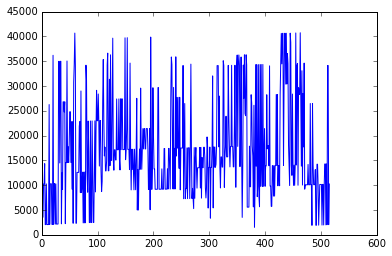

In [30]:
plt.plot(Harry_Draco_sentence_indexes)

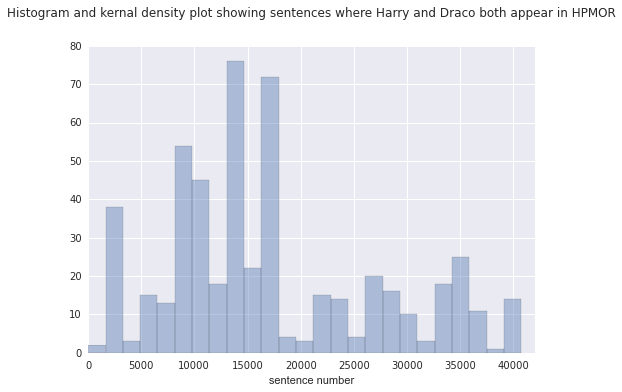

In [46]:
# plot a histogram showing where the sentences occur in the text
import seaborn as sns  #importing this down here as it messes up the lexical dispersion plot above
plt.xlim(0,42000)
Harry_Draco_hist = sns.distplot(Harry_Draco_sentence_indexes, bins = 25, axlabel = "sentence number", kde = False)

pylab.title("Histogram and kernal density plot showing sentences where Harry and Draco both appear in HPMOR", y=1.08)

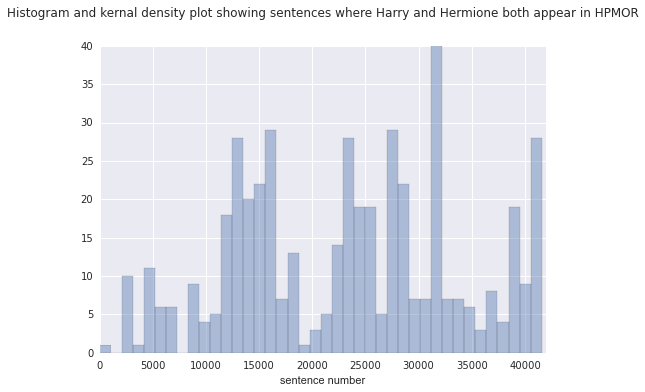

In [47]:
# plot a histogram showing where the sentences occur in the text
Hermione_list = ["Hermione","Granger", "Sunshine General"]
Harry_Hermione_sentence_indexes = characters_sentence_indexes(Harry_list,Hermione_list)
Harry_Hermione_hist = sns.distplot(Harry_Hermione_sentence_indexes, bins = 40, axlabel = "sentence number", kde = False)
plt.xlim(0,42000)
pylab.title("Histogram and kernal density plot showing sentences where Harry and Hermione both appear in HPMOR", y=1.08)

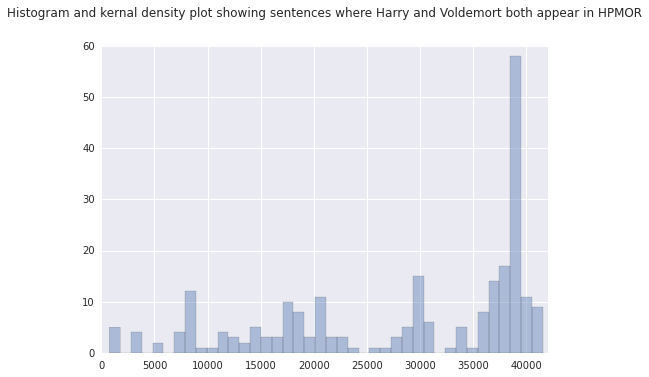

In [49]:
Voldemort_list = ["Voldemort","He-Who-Must-Not-Be-Named","Dark Lord"]
Harry_Voldemort_sentence_indexes = characters_sentence_indexes(Harry_list,Voldemort_list)
len(Harry_Voldemort_sentence_indexes)
Harry_Voldemort_hist = sns.distplot(Harry_Voldemort_sentence_indexes, bins = 40, kde = False)
plt.xlim(0,42000)
pylab.title("Histogram and kernal density plot showing sentences where Harry and Voldemort both appear in HPMOR", y=1.08)

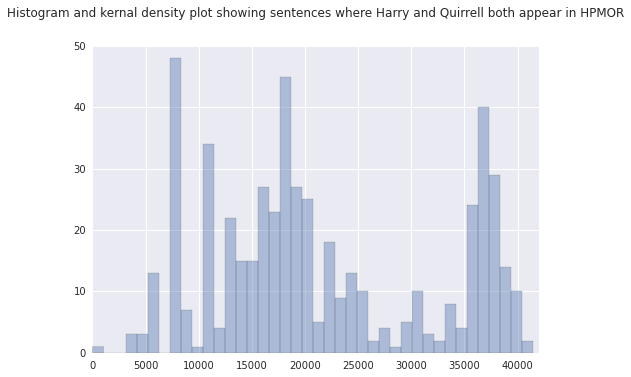

In [50]:
Quirrell_list = ["Quirrell"]
Harry_Quirrell_sentence_indexes = characters_sentence_indexes(Harry_list,Quirrell_list)
len(Harry_Quirrell_sentence_indexes)
Harry_Quirrell_hist = sns.distplot(Harry_Quirrell_sentence_indexes, bins = 40, kde = False)
plt.xlim(0,42000)
pylab.title("Histogram and kernal density plot showing sentences where Harry and Quirrell both appear in HPMOR", y=1.08)

#### Note the simultaneous spike for Quirrell and Voldemort after sentence 35000. It is around this point in the book that both characters are revealed to be the same person.

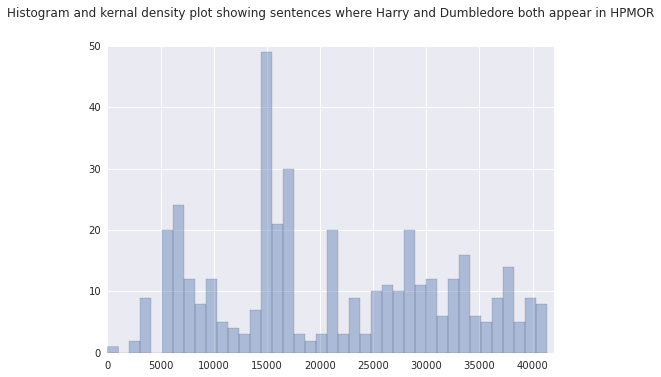

In [51]:
Dumbledore_list = ["Dumbledore", "Headmaster", "headmaster"]
Harry_Quirrell_sentence_indexes = characters_sentence_indexes(Harry_list,Dumbledore_list)
len(Harry_Quirrell_sentence_indexes)
Harry_Quirrell_hist = sns.distplot(Harry_Quirrell_sentence_indexes, bins = 40, kde = False)
plt.xlim(0,42000)
pylab.title("Histogram and kernal density plot showing sentences where Harry and Dumbledore both appear in HPMOR", y=1.08)

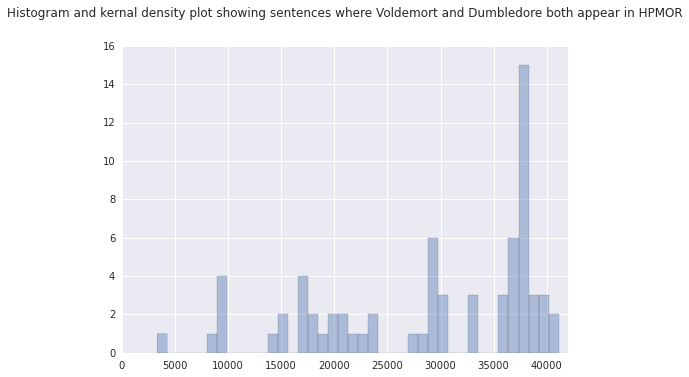

In [52]:
Voldemort_Dumbledore_sentence_indexes = characters_sentence_indexes(Voldemort_list,Dumbledore_list)
Voldemort_Dumbledore_hist = sns.distplot(Voldemort_Dumbledore_sentence_indexes, bins = 40, kde = False)
plt.xlim(0,42000)
pylab.title("Histogram and kernal density plot showing sentences where Voldemort and Dumbledore both appear in HPMOR", y=1.08)

In [58]:
Harry_Dumbledore_sentence_indexes = characters_sentence_indexes(Harry_list,Dumbledore_list)

#### Data visualisation: Character networks

I want to display this information as a network diagram

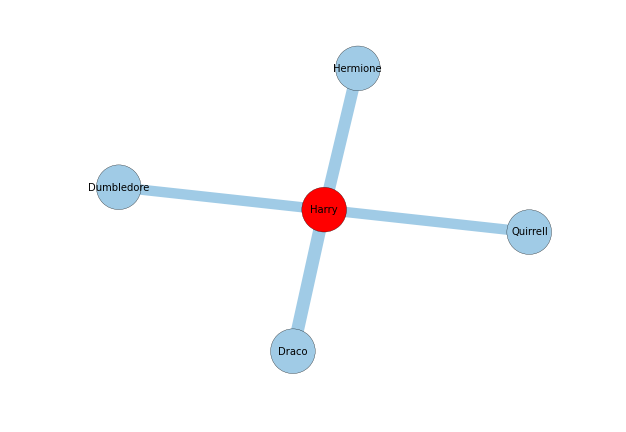

In [59]:
# experimenting with networkx. I want the thicknesses of the edges to correspond to the number of interactions. 
# This will probably mean passing a dict of characters with frozen sets as keys
# e.g. character_interactions = {[frozenset(['Harry', 'Hermione])] =  45]}

number_of_characters =  4
G=nx.star_graph(number_of_characters)
pos=nx.spring_layout(G)
node_colors = (['#ff0000'] + ['#A0CBE6']*(number_of_characters)) # only colour Harry red

nx.draw(G,pos,node_color= node_colors,edge_color='#A0CBE6',width=[len(Harry_Hermione_sentence_indexes)/40,len(Harry_Draco_sentence_indexes)/40,len(Harry_Quirrell_sentence_indexes)/40, len(Harry_Dumbledore_sentence_indexes)/40],node_size = 2000, edge_cmap=plt.cm.Greens,with_labels=False)

#labels
labels={}
labels[0]='Harry'
labels[1]='Hermione'
labels[2]='Draco'
labels[3]='Quirrell'
labels[4]='Dumbledore'

nx.draw_networkx_labels(G,pos,labels,font_size=10)
plt.show() # display

Below is work in progress

In [ ]:
def character_sentence_indexes(a):
    l = [i for i in range(num_sentences) for A in a if (A in sentence_list[i])]
    return list(set(l))     # first converting to a set removes the duplicates     

In [ ]:
h = character_sentence_indexes(Harry_list)

In [ ]:
# apply the function to find the sentence indices where both characters feature
Harry_sentence_indexes = character_sentence_indexes(Harry_list)
Harry_sentence_indexes = list(Harry_sentence_indexes)
"the number of sentences where Harry is mentioned is %d" %len(Harry_sentence_indexes)

In [ ]:
# apply the function to find the sentence indices where both characters feature
Draco_sentence_indexes = character_sentence_indexes(Draco_list)
Draco_sentence_indexes = list(Draco_sentence_indexes)
"the number of sentences where Draco is mentioned is %d" %len(Draco_sentence_indexes)